# LDA Topic Model 

This code is pulled from:
* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
* https://highdemandskills.com/topic-modeling-lda/

## Import Libraries

In [1]:
import pandas as pd

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/connorgilmore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import models

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/connorgilmore/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
extended_stop_words = ['guys', 'syndicated', 'mentoring', 'syndicate', 'club', 'mentor', 'thing', 'people', 'really',
                      'syndication', 'call', 'person', 'stuff']
stop_words.extend(extended_stop_words)

## Import Data

In [5]:
transcripts_df = pd.read_csv('transcripts_df.csv')

In [6]:
transcripts_df.head()

,Unnamed: 0,file_name,contents
0,0,[UPDATED] PC - February 2021 - Mastermind with...,"other hand if he says, You give me 5% of every..."
1,1,"April 8, 2021 - Ask the Mentors Q_A Call on De...","JO\n\noften, it's 100%, smokescreen, nobody li..."
2,2,"April 14, 2021 - Ask the Mentors Q_A Call on C...","JO\n\nJO\n\nbelieve in that, and then develop ..."
3,3,April 2021 - Ask the Mentors Q_A Call on Busin...,JO\n\nyour investor questionnaire. So you can ...
4,4,April 2021 - Ask the Mentors Q_A Call on Sales...,©) Craig Kamman_ 30:35\n\nJO\n\nyes. Okay. So ...


In [7]:
with open('real_estate_terms.txt') as f:
    real_estate_raw = [line.rstrip() for line in f]

## Data Prep

In [8]:
real_estate_terms = []
for word in real_estate_raw:
    word = word.lower()
    word = word.replace("-", "_")
    if (' ' in word):
        words = word.split()
        new_word = '_'.join(words)
        real_estate_terms.append(new_word)
    else:
        real_estate_terms.append(word)

In [9]:
data = transcripts_df['contents']
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [11]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def remove_extra_stopwords(texts):
    new_outer_list = []
    for l in texts:
        inner_list = []
        for word in l:
            if (word not in extended_stop_words):
                inner_list.append(word)
        new_outer_list.append(inner_list)
    return new_outer_list 

def keep_real_estate_terms(texts):
    new_outer_list = []
    for l in texts:
        inner_list = []
        for word in l:
            if (word in real_estate_terms):
                inner_list.append(word)
        new_outer_list.append(inner_list)
    return new_outer_list 
        
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
data_words_nostops = remove_extra_stopwords(data_words_nostops)
#data_words_nostops = keep_real_estate_terms(data_words_nostops)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])

## LDA

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [14]:
TFIDF = models.TfidfModel(corpus) # Fit TF-IDF model
trans_TFIDF = TFIDF[corpus]

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    i = start 
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print('Model ', i , ' Completed')
        i += 1

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=trans_TFIDF, texts=data_lemmatized, 
                                                        start=5, limit=20, step=1)

## Visualize Performance Metrics

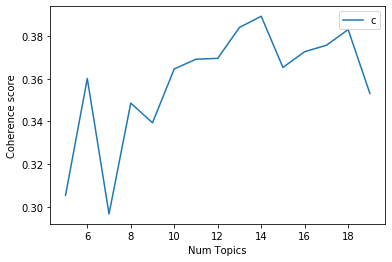

In [21]:
limit=20; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3054
Num Topics = 6  has Coherence Value of 0.3601
Num Topics = 7  has Coherence Value of 0.2966
Num Topics = 8  has Coherence Value of 0.3486
Num Topics = 9  has Coherence Value of 0.3394
Num Topics = 10  has Coherence Value of 0.3646
Num Topics = 11  has Coherence Value of 0.3692
Num Topics = 12  has Coherence Value of 0.3696
Num Topics = 13  has Coherence Value of 0.3841
Num Topics = 14  has Coherence Value of 0.3893
Num Topics = 15  has Coherence Value of 0.3653
Num Topics = 16  has Coherence Value of 0.3727
Num Topics = 17  has Coherence Value of 0.3757
Num Topics = 18  has Coherence Value of 0.3831
Num Topics = 19  has Coherence Value of 0.3531


Optimal Model

In [23]:
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.001*"contingency" + 0.001*"tariff" + 0.001*"bond" + 0.001*"sub" + '
  '0.001*"imbalance" + 0.001*"lease" + 0.001*"tenant" + 0.001*"inspection" + '
  '0.001*"team" + 0.001*"exit" + 0.001*"fund" + 0.001*"contract" + '
  '0.001*"utility" + 0.001*"yield" + 0.001*"coverage_counsel" + '
  '0.001*"transaction" + 0.001*"chinese_good" + 0.001*"seller" + '
  '0.001*"redundancy" + 0.001*"debt" + 0.001*"partner" + 0.001*"exposure" + '
  '0.001*"stacy" + 0.001*"newsletter" + 0.001*"return" + 0.001*"entitlement" + '
  '0.001*"joint_venture" + 0.001*"shotgun" + 0.001*"marketing" + '
  '0.000*"compliance"'),
 (1,
  '0.001*"biggest_mistake" + 0.001*"golf_course" + 0.001*"private_placement" + '
  '0.001*"ppm" + 0.001*"stress" + 0.001*"tank" + 0.001*"exemption" + '
  '0.001*"organization" + 0.001*"inflation" + 0.001*"wage" + 0.001*"land" + '
  '0.001*"hotel" + 0.001*"entrepreneur" + 0.001*"golf" + 0.001*"article" + '
  '0.001*"cryptocurrency" + 0.001*"lender" + 0.001*"bank" + '
  '0.000*"solici